## Create PyTorch Dataset

In [20]:
import pandas as pd
from glob import  glob
import json
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import StratifiedKFold
import torch
import numpy as np

In [21]:
image_path = glob('./datasets/default/train/images/*')

In [22]:
label_path = glob('./datasets/default/train/annotations/*')

In [23]:
assert len(image_path) == 60578

In [24]:
assert len(label_path)== 60578

### Understanding `max_patches` argument

The paper introduces a new paradigm for processing the input image. It takes the image and create `n_patches` aspect-ratio preserving patches, and concatenates the remaining sequence with padding tokens to finally get `max_patches` patches. It appears that this argument is quite crucial for training and evaluation, as the model becomes very sensitive to this parameter.

For the sake of our example, we will fine-tune a model with `max_patches=1024`.

Note that most of the `-base` models have been fine-tuned with `max_patches=2048`, and `4096` for `-large` models.

In [25]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm.notebook import tqdm
MAX_PATCHES = 2048

class ImageCaptioningDataset(Dataset):
    def __init__(self, df, processor):
        self.dataset = df
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx, :]
        image = Image.open(row.image_path)
        #display(image)
        encoding = self.processor(images=image,
                                  text="Generate underlying data table of the figure below:",
                                  font_path="arial.ttf",
                                  return_tensors="pt",
                                  add_special_tokens=True, max_patches=MAX_PATCHES)
        
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = row.label + ' ' + processor.tokenizer.eos_token
        return encoding

## Load model and processor

In [26]:
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration, AutoConfig

processor = Pix2StructProcessor.from_pretrained("./deplot")
config = AutoConfig.from_pretrained("./deplot")
model = Pix2StructForConditionalGeneration.from_pretrained("./deplot")

In [27]:
# print(len(processor.tokenizer))

In [28]:
# new_tokens = ['<x_start>' , '<x_end>', '<y_start>', '<y_end>']
# processor.tokenizer.add_tokens(new_tokens)

In [29]:
# print(len(processor.tokenizer))

In [30]:
# model.decoder.resize_token_embeddings(len(processor.tokenizer))

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [31]:
def collator(batch):
    new_batch = {"flattened_patches": [], "attention_mask": []}
    texts = [item["text"] for item in batch]
    # print(texts)
    text_inputs = processor.tokenizer(text=texts,
                                      padding="max_length",
                                      return_tensors="pt",
                                      add_special_tokens=True,
                                      max_length=512,
                                      truncation=True
                                      )

    new_batch["labels"] = text_inputs.input_ids

    for item in batch:
        new_batch["flattened_patches"].append(item["flattened_patches"])
        new_batch["attention_mask"].append(item["attention_mask"])

    new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
    new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

    return new_batch

## Inference

Let's check the results on our train dataset

In [32]:
model.load_state_dict(torch.load('./weights/deplot_v4/deplot_v4v4v4v4_1.bin', map_location='cuda:3'))
model.eval()

Pix2StructForConditionalGeneration(
  (encoder): Pix2StructVisionModel(
    (embeddings): Pix2StructVisionEmbeddings(
      (patch_projection): Linear(in_features=768, out_features=768, bias=True)
      (row_embedder): Embedding(4096, 768)
      (column_embedder): Embedding(4096, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Pix2StructVisionEncoder(
      (layer): ModuleList(
        (0): Pix2StructVisionLayer(
          (attention): Pix2StructVisionAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=False)
            (output): Linear(in_features=768, out_features=768, bias=False)
          )
          (mlp): Pix2StructVisionMlp(
            (wi_0): Linear(in_features=768, out_features=2048, bias=False)
            (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [33]:
def display_deplot_output(deplot_output):
    '''
    The raw output of deplot
    TITLE | Rural population (%) long-run with 2050 projections<0x0A>(OWID) in Greece<0x0A>Years | Rural population<0x0A>1940 | 47.38<0x0A>1960 | 43.68<0x0A>1980 | 30.28<0x0A>...
    '''
    
    

    x = []
    y = []
    x = []
    y = []
    if '<x_end> <y_start>' not in deplot_output:
        return 
    a, b = deplot_output.split('<x_end> <y_start>')
    x += [i.strip() for i in a.replace('<x_start>', '').split(';') ]
    y += [i.strip() for i in b.replace('<y_end>', '').split(';') ]
    df = pd.DataFrame({'x': x,
            'y': y,
            })
    df.drop_duplicates(inplace=True)
    print(df)



def deplot(path, model, processor, device):
    image = Image.open(path)
    display(image)
    inputs = processor(images=image, text="Generate underlying data table of the figure below:", return_tensors="pt")

    # Move inputs to GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}

    predictions = model.generate(**inputs, max_new_tokens=512,)
    print('-------------------\n', predictions, '\n---------------------------')
    return processor.decode(predictions[0], skip_special_tokens=True)

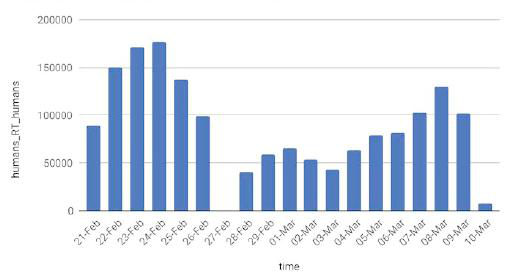

-------------------
 tensor([[    0,   411,   567,   326,  4923,   371,   279,   277,   288, 32815,
           324,   279,   279,   288, 32815,   324,   279,   285,   288, 32815,
           324,   279,   289,   288, 32815,   324,   279,   290,   288, 32815,
           324,   279,   293,   288, 32815,   324,   279,   295,   288, 32815,
           324,   279,   294,   288, 32815,   324,   279,   292,   288, 32815,
           324,   278,   277,   288, 18300,   324,   278,   279,   288, 18300,
           324,   278,   285,   288, 18300,   324,   278,   289,   288, 18300,
           324,   278,   290,   288, 18300,   324,   278,   293,   288, 18300,
           324,   278,   295,   288, 18300,   324,   278,   294,   288, 18300,
           324,   278,   292,   288, 18300,   324,   277,   278,   288, 18300,
           589,   567,   326,  2658,   371,   411,   506,   326,  4923,   371,
           294,   292,   278,   278,   278,   324,   277,   290,   278,   278,
           278,   278,   324,  

In [41]:
device = "cuda:1"
bar_path = './datasets/default/test/images/01b45b831589.jpg' # 000b92c3b098 007a18eb4e09 00dcf883a459 00f5404753cf 01b45b831589 
model.to(device)
deplot_output=deplot(bar_path, model, processor, device)
display_deplot_output(deplot_output)

In [37]:
deplot_output

'<x_start>21-Feb;22-Feb;23-Feb;24-Feb;25-Feb;26-Feb;27-Feb;28-Feb;29-Feb;01-Mar;02-Mar;03-Mar;04-Mar;05-Mar;06-Mar;07-Mar;08-Mar;09-Mar;10-Mar<x_end> <y_start>89000;150000;170000;177000;137000;98000;0;40000;59000;65000;53000;43000;63000;79000;81000;102000;130000;101000;9000<y_end>'

In [22]:
import re

x_pattern = r"<x_start>(.*?)<x_end>"
y_pattern = r"<y_start>(.*?)<y_end>"

x_match = re.search(x_pattern, deplot_output)
y_match = re.search(y_pattern, deplot_output)

if x_match and y_match:
    x_values = x_match.group(1).split(";")
    y_values = y_match.group(1).split(";")

    deplot_output = ""
    for x, y in zip(x_values, y_values):
        deplot_output += f"<0x0A>{x.strip()}|{y.strip()}"

deplot_output += "<0x0A>"

deplot_output

'<0x0A>0|0.008761238761238761<0x0A>6|-1.3258333333333333<0x0A>12|-2.660666666666666<0x0A>18|-1.9202727272727273<0x0A>24|-1.2660666666666666<0x0A>'

In [25]:
deplot_output = deplot_output.replace("<0x0A>", "\n").replace("|", "\t")
deplot_output

'<x_start>1.0086666666666667;2.008666666666666;3.008666666666666;4.008666666666666;5.008666666666667;6.008666666666667;7.008666666666667;8.008666666666667;9.008666666666667;10.008666666666667;11.008666666666667;12.008666666666667;13.008666666666667;14.008666666666667;15.008666666666667;16.008666666666667;17.008666666666667;18.008666666666667;19.008666666666667;20.008666666666667;21.008666666666667;22.008666666666667;23.008666666666667;24.008666666666667;25.008666666666667;25.99999999999999;26.008666666666667;27.\n'

In [17]:
val_df = pd.read_csv('./datasets/default/train_with_fold.csv')

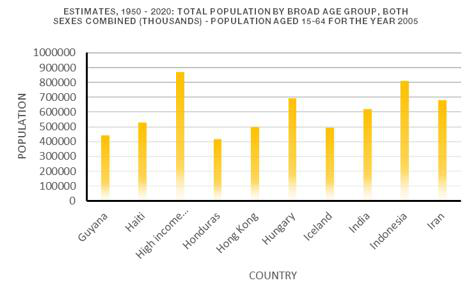

-------------------
 tensor([[    0,   411,   567,   326,  4923,   371, 41206, 33278,   324, 14632,
         13519,   324, 20079,  1703,   425,   324, 16296,  1830,  9217,   287,
           324,  1098, 11755,  5524,   324,  1098,  4657,  8151,   324, 48800,
          3162,   324, 20614,   324,  1773, 11259, 19951,   324, 46133,   589,
           567,   326,  2658,   371,   411,   506,   326,  4923,   371,   289,
           289,   285,   292,   290,   290,   274,   292,   295,   277,   295,
           292,   294,   289,   278,   292,   292,   324,   290,   279,   292,
           295,   277,   295,   274,   292,   294,   289,   278,   292,   292,
           278,   278,   295,   293,   324,   294,   293,   294,   279,   285,
           290,   274,   290,   292,   295,   277,   295,   292,   294,   289,
           278,   292,   324,   289,   277,   294,   279,   285,   290,   274,
           290,   292,   295,   277,   295,   292,   294,   289,   278,   292,
           293,   324,   290,  

'<x_start>Guyana;Haiti;High income...;Honduras;Hong Kong;Hungary;Iceland;India;Indonesia;Iran<x_end> <y_start>443955.9717984099;529717.9840990076;868235.5971798409;418235.59717984096;501235.59717984096;692355.9717984099;496409.9007602355;618235.59717984096;808235.59717984096;678235.59717984096<y_end>'

In [19]:
bar_path =  val_df[val_df['types'] == 'vertical_bar'].image_path.values[0]
deplot_output=deplot(bar_path, model, processor, 'cuda:2')
deplot_output

In [23]:
deplot_output

'<x_start>Group 1;Group 2<x_end> <y_start>3.6303896153896154;8.398961538961539<y_end>'

In [24]:
val_df
bar_path =  val_df[val_df['types'] == 'line'].image_path.values[0]
deplot_output=deplot(bar_path, model, processor, 'cuda')
display_deplot_output(deplot_output)

NameError: name 'val_df' is not defined

In [ ]:
bar_path =  val_df[val_df['types'] == 'scatter'].image_path.values[1]
deplot_output=deplot(bar_path, model, processor, 'cuda')
display_deplot_output(deplot_output)

In [ ]:
bar_path =  val_df[val_df['types'] == 'dot'].image_path.values[0]
deplot_output=deplot(bar_path, model, processor, 'cuda')
display_deplot_output(deplot_output)

In [ ]:
deplot_output

## EVAL

In [31]:
model.load_state_dict(torch.load('./matcha_v1/matcha_0.bin'))
model.eval()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [29]:
from typing import List, Dict, Union, Tuple, Any
import numpy as np
import regex as re
from polyleven import levenshtein
import ast

ModuleNotFoundError: No module named 'polyleven'

In [ ]:

def rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The Root Mean Square Error.
    """
    return np.sqrt(np.mean(np.square(np.subtract(y_true, y_pred))))


def sigmoid(x: float) -> float:
    """
    Calculate the sigmoid function for the given value.

    Args:
        x (float): The input value.

    Returns:
        float: The result of the sigmoid function.
    """
    return 2 - 2 / (1 + np.exp(-x))


def normalized_rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the normalized Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The normalized Root Mean Square Error.
    """
    numerator = rmse(y_true, y_pred)
    denominator = rmse(y_true, np.mean(y_true))

    # https://www.kaggle.com/competitions/benetech-making-graphs-accessible/discussion/396947
    if denominator == 0:
        if numerator == 0:
            return 1.0
        return 0.0

    return sigmoid(numerator / denominator)


def normalized_levenshtein_score(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calculate the normalized Levenshtein distance between two lists of strings.

    Args:
        y_true (List[str]): The true values.
        y_pred (List[str]): The predicted values.

    Returns:
        float: The normalized Levenshtein distance.
    """
    total_distance = np.sum([levenshtein(yt, yp) for yt, yp in zip(y_true, y_pred)])
    length_sum = np.sum([len(yt) for yt in y_true])
    return sigmoid(total_distance / length_sum)


def score_series(
        y_true: List[Union[float, str]], y_pred: List[Union[float, str]]
) -> float:
    """
    Calculate the score for a series of true and predicted values.

    Args:
        y_true (List[Union[float, str]]): The true values.
        y_pred (List[Union[float, str]]): The predicted values.

    Returns:
        float: The score for the series.
    """
    if len(y_true) != len(y_pred):
        return 0.0
    if isinstance(y_true[0], str):
        return normalized_levenshtein_score(y_true, y_pred)
    else:
        # Since this is a generative model, there is a chance it doesn't produce a float.
        # In that case, we return 0.0.
        try:
            return normalized_rmse(y_true, list(map(float, y_pred)))
        except:
            return 0.0


def benetech_score(ground_truth: pd.DataFrame, predictions: pd.DataFrame) -> float:
    """Evaluate predictions using the metric from the Benetech - Making Graphs Accessible.

    Parameters
    ----------
    ground_truth: pd.DataFrame
        Has columns `[data_series, chart_type]` and an index `id`. Values in `data_series`
        should be either arrays of floats or arrays of strings.

    predictions: pd.DataFrame
    """
    if not ground_truth.index.equals(predictions.index):
        raise ValueError(
            "Must have exactly one prediction for each ground-truth instance."
        )
    if not ground_truth.columns.equals(predictions.columns):
        raise ValueError(f"Predictions must have columns: {ground_truth.columns}.")
    pairs = zip(
        ground_truth.itertuples(index=False), predictions.itertuples(index=False)
    )
    scores = []
    for (gt_series, gt_type), (pred_series, pred_type) in pairs:
        if gt_type != pred_type:  # Check chart_type condition
            scores.append(0.0)
        else:  # Score with RMSE or Levenshtein as appropriate
            scores.append(score_series(gt_series, pred_series))

    ground_truth["score"] = scores

    grouped = ground_truth.groupby("chart_type", as_index=False)["score"].mean()

    chart_type2score = {
        chart_type: score
        for chart_type, score in zip(grouped["chart_type"], grouped["score"])
    }

    return np.mean(scores), chart_type2score


def string2triplet(pred_string: str, chart_type: str) -> Tuple[str, List[str], List[str]]:
    """
    Convert a prediction string to a triplet of chart type, x values, and y values.

    Args:
        pred_string (str): The prediction string.

    Returns:
        Tuple[str, List[str], List[str]]: A triplet of chart type, x values, and y values.
    """

    x = []
    y = []
    
    if '<x_end> <y_start>' not in deplot_output:
        return 
    a, b = deplot_output.split('<x_end> <y_start>')
    x += [i.strip() for i in a.replace('<x_start>', '').split(';') ]
    y += [i.strip() for i in b.replace('<y_end>', '').split(';') ]

    if len(x) == 0 or len(y) == 0:
        return chart_type, [], []

    min_length = min(len(x), len(y))

    x = x[:min_length]
    y = y[:min_length]

    return chart_type, x, y


def validation_metrics(val_outputs: List[str], val_ids: List[str], gt_df: pd.DataFrame) -> Dict[str, float]:
    """
    Calculate validation metrics for a set of outputs, ids, and ground truth dataframe.

    Args:
        val_outputs (List[str]): A list of validation outputs.
        val_ids (List[str]): A list of validation ids.
        gt_df (pd.DataFrame): The ground truth dataframe.

    Returns:
        Dict[str, float]: A dictionary containing the validation scores.
    """
    pred_triplets = []

    for row_no, example_output in enumerate(val_outputs):
        pred_triplets.append(string2triplet(example_output, gt_df['types'].values[row_no]))

    pred_df = pd.DataFrame(
        index=[f"{id_}_x" for id_ in val_ids] + [f"{id_}_y" for id_ in val_ids],
        data={
            "data_series": [x[1] for x in pred_triplets]
                           + [x[2] for x in pred_triplets],
            "chart_type": [x[0] for x in pred_triplets] * 2,
        },
    )

    lables = [ast.literal_eval(_) for _ in gt_df['gts']]
    gt_x = []
    gt_y = []
    for label in lables:
        tmp_x, tmp_y = [], []
        for i in label:
            tmp_x.append(i['x'])
            tmp_y.append(i['y'])
        gt_x.append(tmp_x)
        gt_y.append(tmp_y)

    gt_df = pd.DataFrame(
        index=[f"{id_}_x" for id_ in val_ids] + [f"{id_}_y" for id_ in val_ids],
        data={
            "data_series": gt_x + gt_y,
            "chart_type": [x[0] for x in pred_triplets] * 2,
        },
    )
    overall_score, chart_type2score = benetech_score(
        gt_df, pred_df
    )

    return {
        "val_score": overall_score,
        **{f"{k}_score": v for k, v in chart_type2score.items()},
    }


def deplot(path, model, processor, device):
    image = Image.open(path)
    inputs = processor(images=image, text="Generate underlying data table of the figure below:", return_tensors="pt")

    # Move inputs to GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}

    predictions = model.generate(**inputs, max_new_tokens=512, num_beams=4)
    return processor.decode(predictions[0], skip_special_tokens=True)


def infer(model, dataloader, val_df):
    model.eval()
    result = []
    for idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        flattened_patches = batch.pop("flattened_patches").to(device)
        attention_mask = batch.pop("attention_mask").to(device)
        
        with torch.no_grad():
            outputs = model.generate(flattened_patches=flattened_patches,
                                     attention_mask=attention_mask,
                                     max_new_tokens=512, )
        outputs = processor.batch_decode(outputs, skip_special_tokens=True)
        result.extend(outputs)
    val_df_ids = [i.split('/')[-1].replace('.jpg', '') for i in val_df['image_path'].values]
    score = validation_metrics(result, val_df_ids, val_df)
    return score

In [25]:
val_df = df[df['fold'] == 0]
#val_df = val_df[val_df['source']=='extracted']
val_df.reset_index(drop=True, inplace=True)

val_dataset = ImageCaptioningDataset(val_df, processor)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=8, collate_fn=collator, pin_memory=True,
                                prefetch_factor=60, num_workers=4)

NameError: name 'df' is not defined

In [32]:
result = infer(model, val_dataloader, val_df)

NameError: name 'infer' is not defined

In [ ]:
result